(stellar-variability)=

# Gaussian process models for stellar variability

In [1]:
import exoplanet

exoplanet.utils.docs_setup()
print(f"exoplanet.__version__ = '{exoplanet.__version__}'")

exoplanet.__version__ = '0.5.4.dev27+g75d7fcc'


When fitting exoplanets, we also need to fit for the stellar variability and Gaussian Processes (GPs) are often a good descriptive model for this variation.
[PyMC3 has support for all sorts of general GP models](https://docs.pymc.io/gp.html), but *exoplanet* interfaces with the [celerite2](https://celerite2.readthedocs.io/) library to provide support for scalable 1D GPs (take a look at the [Getting started](https://celerite2.readthedocs.io/en/latest/tutorials/first/) tutorial on the *celerite2* docs for a crash course) that can work with large datasets.
In this tutorial, we go through the process of modeling the light curve of a rotating star observed by Kepler using *exoplanet* and *celerite2*.

First, let's download and plot the data:

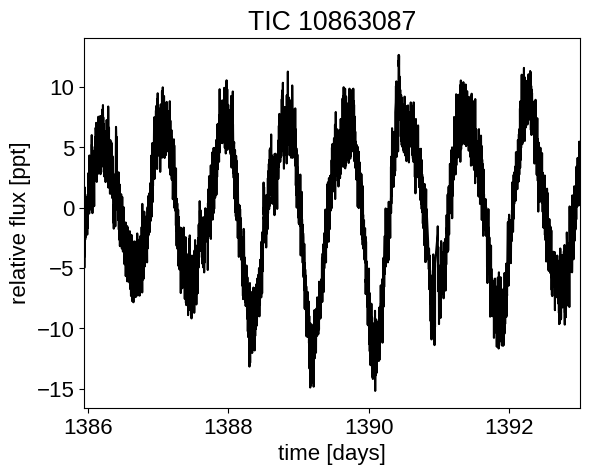

In [2]:
import numpy as np
import lightkurve as lk
import matplotlib.pyplot as plt

lcf = lk.search_lightcurve(
    "TIC 10863087", mission="TESS", author="SPOC"
).download_all(quality_bitmask="hardest", flux_column="pdcsap_flux")
lc = lcf.stitch().remove_nans().remove_outliers()
lc = lc[:5000]
_, mask = lc.flatten().remove_outliers(sigma=3.0, return_mask=True)
lc = lc[~mask]

x = np.ascontiguousarray(lc.time.value, dtype=np.float64)
y = np.ascontiguousarray(lc.flux, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err, dtype=np.float64)
mu = np.mean(y)
y = (y / mu - 1) * 1e3
yerr = yerr * 1e3 / mu

plt.plot(x, y, "k")
plt.xlim(x.min(), x.max())
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
_ = plt.title("TIC 10863087")

## A Gaussian process model for stellar variability

This looks like the light curve of a rotating star, and [it has been shown](https://arxiv.org/abs/1706.05459) that it is possible to model this variability by using a quasiperiodic Gaussian process.
To start with, let's get an estimate of the rotation period using the Lomb-Scargle periodogram:

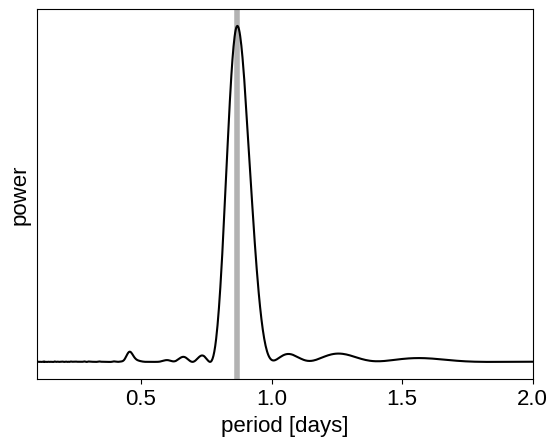

In [3]:
import exoplanet as xo

results = xo.estimators.lomb_scargle_estimator(
    x, y, max_peaks=1, min_period=0.1, max_period=2.0, samples_per_peak=50
)

peak = results["peaks"][0]
freq, power = results["periodogram"]
plt.plot(1 / freq, power, "k")
plt.axvline(peak["period"], color="k", lw=4, alpha=0.3)
plt.xlim((1 / freq).min(), (1 / freq).max())
plt.yticks([])
plt.xlabel("period [days]")
_ = plt.ylabel("power")

Now, using this initialization, we can set up the GP model in *exoplanet* and *celerite2*.
We'll use the [RotationTerm](https://celerite2.readthedocs.io/en/latest/api/python/#celerite2.terms.RotationTerm) kernel that is a mixture of two simple harmonic oscillators with periods separated by a factor of two.
As you can see from the periodogram above, this might be a good model for this light curve and I've found that it works well in many cases.

In [4]:
import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt
from celerite2.theano import terms, GaussianProcess

with pm.Model() as model:
    # The mean flux of the time series
    mean = pm.Normal("mean", mu=0.0, sigma=10.0)

    # A jitter term describing excess white noise
    log_jitter = pm.Normal("log_jitter", mu=np.log(np.mean(yerr)), sigma=2.0)

    # A term to describe the non-periodic variability
    sigma = pm.InverseGamma(
        "sigma", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
    )
    rho = pm.InverseGamma(
        "rho", **pmx.estimate_inverse_gamma_parameters(0.5, 2.0)
    )

    # The parameters of the RotationTerm kernel
    sigma_rot = pm.InverseGamma(
        "sigma_rot", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
    )
    log_period = pm.Normal("log_period", mu=np.log(peak["period"]), sigma=2.0)
    period = pm.Deterministic("period", tt.exp(log_period))
    log_Q0 = pm.HalfNormal("log_Q0", sigma=2.0)
    log_dQ = pm.Normal("log_dQ", mu=0.0, sigma=2.0)
    f = pm.Uniform("f", lower=0.1, upper=1.0)

    # Set up the Gaussian Process model
    kernel = terms.SHOTerm(sigma=sigma, rho=rho, Q=1 / 3.0)
    kernel += terms.RotationTerm(
        sigma=sigma_rot,
        period=period,
        Q0=tt.exp(log_Q0),
        dQ=tt.exp(log_dQ),
        f=f,
    )
    gp = GaussianProcess(
        kernel,
        t=x,
        diag=yerr**2 + tt.exp(2 * log_jitter),
        mean=mean,
        quiet=True,
    )

    # Compute the Gaussian Process likelihood and add it into the
    # the PyMC3 model as a "potential"
    gp.marginal("gp", observed=y)

    # Compute the mean model prediction for plotting purposes
    pm.Deterministic("pred", gp.predict(y))

    # Optimize to find the maximum a posteriori parameters
    map_soln = pmx.optimize()

optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -9263.87083670822 -> -8861.082439762553


Now that we have the model set up, let's plot the maximum a posteriori model prediction.

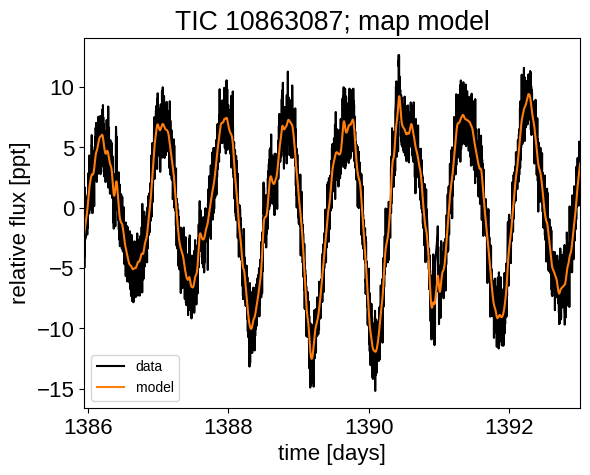

In [5]:
plt.plot(x, y, "k", label="data")
plt.plot(x, map_soln["pred"], color="C1", label="model")
plt.xlim(x.min(), x.max())
plt.legend(fontsize=10)
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
_ = plt.title("TIC 10863087; map model")

That looks pretty good!
Now let's sample from the posterior using [the PyMC3 Extras (pymc3-ext) library](https://github.com/exoplanet-dev/pymc3-ext):

In [6]:
with model:
    trace = pmx.sample(
        tune=1000,
        draws=1000,
        start=map_soln,
        cores=2,
        chains=2,
        target_accept=0.9,
        return_inferencedata=True,
        random_seed=[10863087, 10863088],
    )

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 134 seconds.


Now we can do the usual convergence checks:

In [7]:
import arviz as az

az.summary(
    trace,
    var_names=[
        "f",
        "log_dQ",
        "log_Q0",
        "log_period",
        "sigma_rot",
        "rho",
        "sigma",
        "log_jitter",
        "mean",
    ],
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
f,0.292,0.184,0.100,0.662,0.005,0.004,1684.0,1082.0,1.0
log_dQ,0.783,2.255,-3.353,4.663,0.064,0.047,1259.0,1401.0,1.0
log_Q0,3.733,0.740,2.273,5.128,0.022,0.015,1223.0,809.0,1.0
log_period,-0.133,0.008,-0.148,-0.117,0.000,0.000,1771.0,1299.0,1.0
sigma_rot,3.131,0.609,2.101,4.255,0.014,0.011,1938.0,1523.0,1.0
rho,0.264,0.036,0.204,0.333,0.001,0.001,1863.0,1374.0,1.0
sigma,1.592,0.181,1.266,1.920,0.004,0.003,2014.0,1657.0,1.0
log_jitter,-1.286,0.416,-1.911,-0.794,0.027,0.020,576.0,233.0,1.0
mean,-0.039,0.318,-0.597,0.591,0.008,0.008,1486.0,1150.0,1.0


And plot the posterior distribution over rotation period:

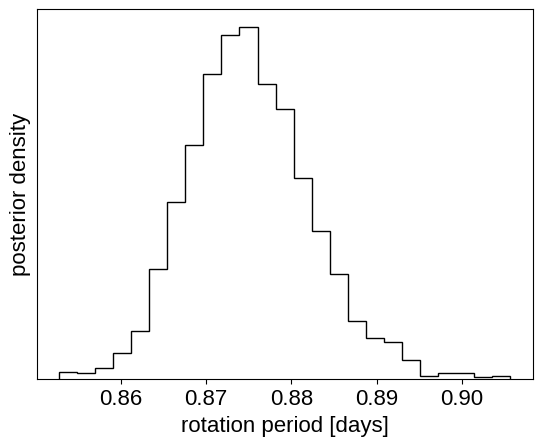

In [8]:
period_samples = np.asarray(trace.posterior["period"]).flatten()
plt.hist(period_samples, 25, histtype="step", color="k", density=True)
plt.yticks([])
plt.xlabel("rotation period [days]")
_ = plt.ylabel("posterior density")

## Citations

As described in the [citation tutorial](https://docs.exoplanet.codes/en/stable/tutorials/citation/), we can use [citations.get_citations_for_model](https://docs.exoplanet.codes/en/stable/user/api/#exoplanet.citations.get_citations_for_model) to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [9]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet:joss,
exoplanet:zenodo} and its dependencies \citep{celerite2:foremanmackey17,
celerite2:foremanmackey18, exoplanet:arviz, exoplanet:pymc3, exoplanet:theano}.


In [10]:
print(bib.split("\n\n")[0] + "\n\n...")


@article{exoplanet:joss,
       author = {{Foreman-Mackey}, Daniel and {Luger}, Rodrigo and {Agol}, Eric
                and {Barclay}, Thomas and {Bouma}, Luke G. and {Brandt},
                Timothy D. and {Czekala}, Ian and {David}, Trevor J. and
                {Dong}, Jiayin and {Gilbert}, Emily A. and {Gordon}, Tyler A.
                and {Hedges}, Christina and {Hey}, Daniel R. and {Morris},
                Brett M. and {Price-Whelan}, Adrian M. and {Savel}, Arjun B.},
        title = "{exoplanet: Gradient-based probabilistic inference for
                  exoplanet data \& other astronomical time series}",
      journal = {arXiv e-prints},
         year = 2021,
        month = may,
          eid = {arXiv:2105.01994},
        pages = {arXiv:2105.01994},
archivePrefix = {arXiv},
       eprint = {2105.01994},
 primaryClass = {astro-ph.IM},
       adsurl = {https://ui.adsabs.harvard.edu/abs/2021arXiv210501994F},
      adsnote = {Provided by the SAO/NASA Astrophysics Data System